In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from typing import List

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Tokenization

### 简介

Tokenization 的主要目的是将文本分解成更小的单位(Tokens)，减小模型输入数据的内在结构复杂度(从句子变为单词序列)，从而简化模型训练的难度。同时将字符的序列转化为 Token 序号的序列，便于模型输入。

Tokenization 首先确定语言的词表划分粒度，一般可分为：

-   字符级：将文本分解为字符。
-   单词级：将文本分解为单词。
-   子词级：将单词进一步分解为更小的有意义单元（如前缀、后缀）。

之后使用预定义的规则来识别 tokens, 或使用统计或机器学习技术来识别最优的 token 切分方式。例如，BPE（Byte Pair Encoding）或 SentencePiece。

最后实现一组文本序列和 Tokens 序列之间相互转化的函数，即可完成 Tokenization 部分。

### 实验要求

1. 实现字符级切分的简单 tokenizer， 由 字符表， 字符到 token 的 encoder()函数 和 token 到字符的 decoder() 函数组成。
2. 调用 现有的 tokenizer 实现，比如 openai 的 tiktoken


In [46]:
class Tokenizer:
    def __init__(self, dataPath: str):
        with open(dataPath, "r", encoding="utf-8") as f:
            self.dataset = f.read()
        self.char2index = {}
        self.index2char = {}
        self.generate_vocabulary()

    def generate_vocabulary(self):
        index = 0
        for char in self.dataset:
            if char not in self.char2index:
                self.char2index[char] = index
                self.index2char[index] = char
                index += 1

    def encode(self, sentence: str) -> torch.Tensor:
        """
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input  : "ABCD"
        output : Tensor([0,1,2,3])

        注意: 为了后续实验方便，输出Tensor的数据类型dtype 为torch.long。
        """
        return torch.tensor(
            [self.char2index[char] for char in sentence], dtype=torch.long
        )

    def decode(self, tokens: torch.Tensor) -> str:
        """
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input : Tensor([0,1,2,3])
        output : "ABCD"
        """
        return "".join([self.index2char[index] for index in tokens])


tokenizer = Tokenizer(dataPath="input.txt")

### 定义 dataloader 和 dataset

为了高效加载数据，我们需要把输入文件接入 PyTorch 的数据加载器中。在这里我们定义 `ShakespeareDataset` 类用于加载数据集，用 PyTorch 的 `DataLoader` 类来实现数据加载。


In [47]:
class ShakespeareDataset(Dataset):
    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, "r", encoding="utf-8") as file:
            text = file.read()
        text = text[: int(len(text) / 20)]
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):

        chunk = self.encoded[idx: idx + self.chunk_size]
        label = self.encoded[idx + 1: idx + self.chunk_size + 1]

        return chunk, label


def create_dataloader(filepath, tokenizer, chunk_size, batch_size, shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)]
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader

注意力的计算公式为：

$$
Head = Attention(x)=Softmax(M\cdot QK^T)V\\
Q=xW_{q},K=xW_{k}, V=xW_{v}
$$

这里实现的一些数学技巧可以参见 attention.ipynb


In [48]:
class HeadAttention(nn.Module):
    def __init__(self, seq_len: int, embed_size: int, hidden_size: int):
        super().__init__()

        self.register_buffer("tril", torch.tril(torch.ones(seq_len, seq_len)))
        self.to_q = nn.Linear(embed_size, hidden_size)
        self.to_k = nn.Linear(embed_size, hidden_size)
        self.to_v = nn.Linear(embed_size, hidden_size)

        nn.init.xavier_uniform_(self.to_q.weight)
        nn.init.xavier_uniform_(self.to_k.weight)
        nn.init.xavier_uniform_(self.to_v.weight)

    def forward(self, inputs):

        inputs.to(device)
        Q = self.to_q(inputs)
        K = self.to_k(inputs)
        V = self.to_v(inputs)
        Attention = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
        Attention = Attention.masked_fill(self.tril == 0, float("-inf"))
        Attention = F.softmax(Attention, dim=-1)
        Attention = torch.matmul(Attention, V).to(inputs.device)
        return Attention

Transformer 中使用的注意力机制时会使用多个注意力头，期望每个注意力头能够注意到不同的信息。
所以实际公式需要修改如下

$$
MultiHeadAttention(x)=[Head_0, Head_1,...,Head_h]W_o\\
Head_i = Attention(x)=Softmax(M\cdot Q_iK_i^T)V_i\\
Q_i=xW_{iq},K=xW_{ik}, V=xW_{iv}
$$

在搭建网络的过程中，同学们可能会用到 nn.ModuleList 这个库，每个$Head_i$的计算可以直接使用上面已经实现的单头注意力计算。
最后对于这些注意力头再使用一个简单的线性层/矩阵$W_o$汇总信息即可


In [49]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads: int, head_size: int, seq_len: int, embed_size: int):
        super().__init__()
        head_size = embed_size // n_heads
        self.heads = nn.ModuleList(
            [HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)]
        )
        self.projection = nn.Linear(embed_size, embed_size)
        nn.init.xavier_uniform_(self.projection.weight)

    def forward(self, inputs):
        inputs.to(device)
        head_outputs = [head(inputs) for head in self.heads]
        MHAttention = torch.cat(head_outputs, dim=-1)
        MHAttention = self.projection(MHAttention).to(inputs.device)
        return MHAttention

## 专家网络 Expert

Expert 即为标准 Transformer 中的 FeedForward 模块。

在经过 MultiHeadAttention 模块后，seq_len 中的每一个 Embedding 都对应了前文信息的加权求和。在经过 FeedForward 模块时，模型对每一个位置的 Embedding 进行了两次线性变换和一次非线性变换，可以视为对当前语境下的信息进行加工。知识编辑的一些研究表明，FeedForword 模块参数包含了大量的事实性知识。

一个直观的想法是，类比于 MultiHeadAttention，我们在每一层训练多个 FeedForward 模块，对于不同位置的 Embedding 使用不同的 FeedForward 模块处理对应的信息。就好像每层有多个 Expert,每个 Expert 都负责处理一类数据的深加工，因此我们称 FeedForward 为 Expert。

实现方面:

FeedForward 层由两层简单的线性层组成，对于一个(batch_size, seq_len, embed_size)输入的向量 x
只在最后一个维度上进行计算，以实现词的特征维度上的交互(注意力机制是词之间的交互)。
其首先用一个线性层将 x 最后一维扩大至原先 4 倍，然后继续用一个线性层还原回原先的维度。


In [50]:
class Expert(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        self.fc1 = nn.Linear(embed_size, embed_size * 4)
        self.fc2 = nn.Linear(embed_size * 4, embed_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, inputs):
        inputs.to(device)
        mid = F.relu(self.fc1(inputs))
        outputs = self.fc2(mid).to(inputs.device)
        return outputs

## 选通网络 TopkRouter

在实现了单个 Expert 后，我们要设计一个选通网络决策每个 Embedding 要使用那个 Expert 计算

### 为了说明选通网络的实现方式，我们定义一下记号：

inputs.shape = [batch_size, seq_len, embed_size] = [1, 8, 16]

即输入有 batch_size=1 个数据点，该数据有 seq_len 长度的 context，即包含 seq_len=8 个 Embedding，每个 Embedding 长度为 embed_dim=16。

记 num_expert = 4, 即该层包含 num_expert 个并列的 Expert。

记 active_expert = 2, 即计算每个 Embedding 仅有 active_expert 个 Expert 参与计算。

### 选通网络计算

对于有 seq_len=8 的数据，如果每个 Expert 都参与计算每一个 Embedding，那么一共需要计算 seq_len\*embed_size = 32 次， 这极大的增加了模型计算量，因此我们往往只激活其中的 active_experts 个 Expert，这要求我们对每一个 Embedding 计算最合适的 active_experts 个 Expert。

对于单个 Expert 的原版 Transformer 来说：

$$
outputs[0,seq] = FeedForward(inputs[0,seq])
$$

对于多个 Expert 的网络：

$$
outputs[0,seq] = \sum_{i \in range(num\_model)} \alpha_{i} Expert_{i}(inputs[0,seq])
$$

$$
\alpha_{i} = \left\{
\begin{array}{ll}
    1 & Expert_{i}  \text{is selected} \\
    0 & Expert_{i}  \text{is not selected} \\
\end{array}
\right.
$$

将$\{\alpha_0,\alpha_1,\dots,\alpha_{num_experts-1}\}$记为向量$\alpha$:

$$
outputs[0,seq] = \alpha \cdot \{Expert_i(inputs[0,seq])\}
$$

一个选通 0,2 号 Expert 的$\alpha$的例子是$[1,0,1,0]$

问题在于如何求得 $\alpha$, 对于一个 Embedding ，我们使用神经网络对每个 Expert 打分，在根据分数计算$\alpha$

$$
score[0,seq] = MLP(inputs[0,seq])  \\
\alpha = topK(score[0,seq])
$$

例如：

$$
score[0,seq] = [11.32,1.54,14.83,-1.90] \\
\alpha = [1,0,1,0]
$$

从优化的角度来说，$\alpha$取前 k 大的分数的下标（即 argmax），这个操作是不可导的，这里我们用之前在"attention.ipynb"中提到的技巧处理这里的计算。

$$
mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
\alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
index = [1,0,1,0]
$$

我们用这个$\alpha$和$index$用做选通网络.


In [51]:

class TopkRouter(nn.Module):
    def __init__(self, embed_size, num_experts, active_experts):
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts),
        )

    def forward(self, inputs):
        inputs.to(device)
        score = self.mlp(inputs)
        indices = torch.topk(score, self.active_experts, dim=-1)[1]
        mask = torch.zeros_like(score, dtype=torch.bool)
        mask.scatter_(dim=-1, index=indices, value=True)

        score = score.masked_fill(~mask, float("-inf"))
        router_output = F.softmax(score, dim=-1)
        router_output = router_output.to(inputs.device)
        return router_output, indices

## 稀疏专家网络 SparseMoE

![moe](./moeSparse.png)

在定义完 Expert 和 TopkRouter 后，我们可以定义 SparseMoE 模块。

在前向过程中，对于 inputs.shape = [Batch_size,seq_len,embed_size]第二维度 seq_len 个 Embedding,我们先利用 TopkRouter 计算出选通专家序号 indices 以及专家权重 router_output。

我们将 Embedding 通过选通的 Expert 得出 active_expert 个新的 Embedding，然后使用 router_output 的作为权重对新的 Embedding 加权求和作为输出。


In [52]:
class SparseMoE(nn.Module):
    def __init__(self, embed_size: int, num_experts: int, active_experts: int):
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts
        self.experts = nn.ModuleList([Expert(embed_size) for _ in range(num_experts)])
        self.router = TopkRouter(embed_size, num_experts, active_experts)

    def forward(self, inputs):

        router_output, indices = self.router(inputs)

        batch_size, seq_len, _ = inputs.size()
        final_output = torch.zeros_like(inputs).to(inputs.device)

        for b in range(batch_size):
            for s in range(seq_len):
                token_inputs = inputs[b, s]

                expert_outputs = []
                for idx in indices[b, s]:
                    output = self.experts[idx](token_inputs.to(inputs.device))
                    expert_outputs.append(output)

                expert_outputs = torch.stack(expert_outputs).to(inputs.device)
                token_router_output = router_output[b, s][indices[b, s]].to(
                    inputs.device
                )
                weighted_sum = torch.sum(
                    token_router_output.unsqueeze(-1) * expert_outputs,
                    dim=0,
                )
                final_output[b, s] = weighted_sum

        return final_output

Transformer 由一层层的 block 堆叠而成，其中每个 block 的结构从模型的结构图展开中可以看到，由 LayerNorm，Masked multi head attention，(SparseMoE)FeedForward 组成。

对于一个表示句子的输入向量 x，其首先会经过 Layer Normalization 层.
Layer Normalization 层对于一个 句子个数 x 句子长度 x 单词向量维度 的输入 x, 会在最后两维上进行规范化处理，起到稳定训练的作用。

$$
LN(x)=\frac{x-mean(x)}{\sqrt{var(x)+\epsilon}}\cdot\gamma+\beta
$$

其中 mean 和 var 都是在最后两个维度上进行的，layernorm 的实现同学们可以直接调用 nn.LayerNorm
经过 layernorm 层后，再经过 Mask multi head attention 层之后，会在+号处再次和原始的输入进行相加，这样的做法能够提高训练的稳定性。有兴趣的同学可以从梯度角度思考原因，或者搜索残差连接相关资料进行学习。
之后再同样经过一层 layernorm 和 feedforwad 之后，就可以得到 block 块的输出了。
即 x' = x+MHA(LN(x)), y = FFN(LN(x'))+x'


In [53]:
class Block(nn.Module):
    def __init__(
        self,
        embed_size: int,
        n_heads: int,
        seq_len: int,
        num_experts: int,
        active_experts: int,
    ):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_size)
        self.layernorm2 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(
            n_heads, embed_size // n_heads, seq_len, embed_size
        )
        self.moe = SparseMoE(embed_size, num_experts, active_experts)

    def forward(self, inputs):
        x = self.layernorm1(inputs)
        x = x + self.attention(x)
        x = self.layernorm2(x)
        x = x + self.moe(x)
        return x

In [54]:
class SparseMoETransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        seq_len: int,
        embed_size: int,
        n_layers: int,
        n_heads: int,
        num_experts: int,
        active_experts: int,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(seq_len, embed_size)
        self.blocks = nn.ModuleList(
            [
                Block(embed_size, n_heads, seq_len, num_experts, active_experts)
                for _ in range(n_layers)
            ]
        )
        self.layernorm = nn.LayerNorm(embed_size)
        self.output_linear = nn.Linear(embed_size, vocab_size)
        nn.init.xavier_uniform_(self.output_linear.weight)

    def forward(self, inputs, labels=None):
        (batch_size, seq_len,) = inputs.shape

        embedding = self.token_embedding(inputs) + self.position_embedding(
            torch.arange(seq_len, device=inputs.device)
        )

        for block in self.blocks:
            embedding = block(embedding)

        logits = self.output_linear(self.layernorm(embedding))

        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        inputs = tokenizer.encode(inputs).clone().detach().unsqueeze(0)
        device = next(self.parameters()).device
        inputs = inputs.to(device)
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, : self.seq_len]
        generated = inputs
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len:]
            else:
                generated_input = generated
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]
            next_token_ids = torch.argmax(last_logits, dim=-1)
            next_token_ids = next_token_ids.unsqueeze(-1)
            generated = torch.cat([generated, next_token_ids], dim=1)
            tmp = generated.clone().detach()
        return generated

# 训练循环

如果你已经完成了模型定义等内容，训练的过程实际上在高度封装的 Pytorch 库中非常简单, 因为你并不需要写对应的反向传播。


#### Loss

Loss 用来**衡量**模型预测与真实值之间的**差距**。

常见的几个 Loss 函数：

-   交叉熵：$\text{CrossEntropy Loss} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$
-   均方误差：$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$
-   绝对误差：$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$

不同的 loss 对应不同的优化目标，如果写错 loss 函数会导致模型不收敛/性能很差。


#### 训练循环

当我们写好 Optimizer 和 Loss 之后，对应的训练循环就十分简单了。

我们只需要做以下事情：

-   从 dataloader 里面拿到一个 batch 的数据以及标签
-   将数据送入模型，进行前向传播
-   拿到模型输出的 logits
-   将 logits 和 标签进行 loss 计算
-   用 Optimizer
    -   清空梯度
    -   反向传播
    -   更新参数


In [55]:
def train(model, dataloader, epoch, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    total_loss = 0
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.clone().detach()
        targets = targets.clone().detach()
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} Loss: {total_loss / len(dataloader)}")

    return total_loss / len(dataloader)


def validate(model, dataloader, epoch, device):
    model.eval()

    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        logits, loss = model(inputs, targets)
        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss / len(dataloader)}")
    return total_loss / len(dataloader)

100%|██████████| 4460/4460 [02:13<00:00, 33.49it/s]


Epoch 0 Loss: 3.6096951497509875
Epoch 0 Loss: 3.289907028643005
Epoch 0 Train Loss: 3.6096951497509875, Valid Loss: 3.289907028643005


100%|██████████| 4460/4460 [02:13<00:00, 33.48it/s]


Epoch 1 Loss: 3.2519449356425505
Epoch 1 Loss: 3.213034803664203
Epoch 1 Train Loss: 3.2519449356425505, Valid Loss: 3.213034803664203


100%|██████████| 4460/4460 [02:15<00:00, 32.87it/s]


Epoch 2 Loss: 3.1659946499918608
Epoch 2 Loss: 3.1215896529467115
Epoch 2 Train Loss: 3.1659946499918608, Valid Loss: 3.1215896529467115


100%|██████████| 4460/4460 [02:23<00:00, 31.19it/s]


Epoch 3 Loss: 3.082691545657513
Epoch 3 Loss: 3.0477690660365493
Epoch 3 Train Loss: 3.082691545657513, Valid Loss: 3.0477690660365493


100%|██████████| 4460/4460 [02:24<00:00, 30.87it/s]


Epoch 4 Loss: 3.017548631178424
Epoch 4 Loss: 2.9905489134681598
Epoch 4 Train Loss: 3.017548631178424, Valid Loss: 2.9905489134681598


100%|██████████| 4460/4460 [02:20<00:00, 31.80it/s]


Epoch 5 Loss: 2.9621864809583656
Epoch 5 Loss: 2.927006961839616
Epoch 5 Train Loss: 2.9621864809583656, Valid Loss: 2.927006961839616


100%|██████████| 4460/4460 [01:52<00:00, 39.80it/s]


Epoch 6 Loss: 2.89566612890483
Epoch 6 Loss: 2.8673643456446216
Epoch 6 Train Loss: 2.89566612890483, Valid Loss: 2.8673643456446216


100%|██████████| 4460/4460 [01:50<00:00, 40.50it/s]


Epoch 7 Loss: 2.8497401293617726
Epoch 7 Loss: 2.829503528740374
Epoch 7 Train Loss: 2.8497401293617726, Valid Loss: 2.829503528740374


100%|██████████| 4460/4460 [01:50<00:00, 40.26it/s]


Epoch 8 Loss: 2.8155824648959755
Epoch 8 Loss: 2.7993782853866374
Epoch 8 Train Loss: 2.8155824648959755, Valid Loss: 2.7993782853866374


100%|██████████| 4460/4460 [01:50<00:00, 40.21it/s]


Epoch 9 Loss: 2.790107076210826
Epoch 9 Loss: 2.7771583518639806
Epoch 9 Train Loss: 2.790107076210826, Valid Loss: 2.7771583518639806


100%|██████████| 4460/4460 [01:51<00:00, 40.11it/s]


Epoch 10 Loss: 2.7695147888008256
Epoch 10 Loss: 2.7579599532311274
Epoch 10 Train Loss: 2.7695147888008256, Valid Loss: 2.7579599532311274


100%|██████████| 4460/4460 [01:52<00:00, 39.73it/s]


Epoch 11 Loss: 2.7526943296595006
Epoch 11 Loss: 2.742855138308264
Epoch 11 Train Loss: 2.7526943296595006, Valid Loss: 2.742855138308264


100%|██████████| 4460/4460 [01:52<00:00, 39.52it/s]


Epoch 12 Loss: 2.7393185983858834
Epoch 12 Loss: 2.731073940815947
Epoch 12 Train Loss: 2.7393185983858834, Valid Loss: 2.731073940815947


100%|██████████| 4460/4460 [01:53<00:00, 39.35it/s]


Epoch 13 Loss: 2.72737950391299
Epoch 13 Loss: 2.718332995213735
Epoch 13 Train Loss: 2.72737950391299, Valid Loss: 2.718332995213735


100%|██████████| 4460/4460 [01:54<00:00, 38.96it/s]


Epoch 14 Loss: 2.7162564202274444
Epoch 14 Loss: 2.7071571277396025
Epoch 14 Train Loss: 2.7162564202274444, Valid Loss: 2.7071571277396025


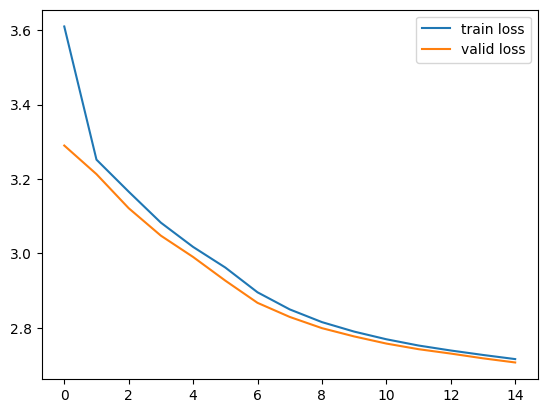

I could pick my lance t t the the the th the the th the th the th the th the th the th the th the th the th the th the t


In [56]:
"""
train_dataloader, val_dataloader = create_dataloader('input.txt', tokenizer, chunk_size=50, batch_size=512)
model = SparseMoETransformer(vocab_size=len(tokenizer.char2index), seq_len=50, embed_size=64, n_layers=1, n_heads=8, num_experts=8, active_experts=2).to(device)

"""

train_dataloader, val_dataloader = create_dataloader(
    "input.txt",
    tokenizer,
    chunk_size=20,
    batch_size=10,
)
model = SparseMoETransformer(
    vocab_size=len(tokenizer.char2index),
    seq_len=20,
    embed_size=4,
    n_layers=1,
    n_heads=1,
    num_experts=2,
    active_experts=1,
).to(device)

model.to(device)


def run(model, train_dataloader, valid_dataloader, device, epochs=0):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        print(f"Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses


def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss, label="train loss")
    plt.plot(valid_loss, label="valid loss")
    plt.legend()
    plt.show()


train_losses, valid_losses = run(
    model, train_dataloader, val_dataloader, device, epochs=15
)
plot_loss(train_losses, valid_losses)


torch.save(model.state_dict(), "model.pth")

model.load_state_dict(torch.load("model.pth"))

print(
    tokenizer.decode(
        model.generate("I could pick my lance", max_new_tokens=100)[0].tolist()
    )
)